# Transfer Kernel Model Simulation

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
import tensorflow as tf
import edward as ed
from edward.models import Normal, Bernoulli
from mgds.data_modeling.nbfn import mkl as mkl
from mgds.data_modeling.nbfn import model_mkl04 as mklmodel
from ml.edward import models as ed_models
from ml.tensorflow.utilities import tf_eval
SEED = 1
RES_DIR = '/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations'

2017-04-19 06:24:01,714:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


# Configuration

In [2]:
# Actual Config
# P = 13415
# Nr = 403
# Nd = 46
# Tr = 169
# Td = 196
# p_rppa = 100
# p_drug = 5

# Large Configuration
P = 600
Nr = 403
Nd = 46
Tr = 169
Td = 25
p_rppa = 50
p_drug = 5
sim_type = 'large'

# Small Config
# P = 600
# Nr = 500
# Nd = 100
# Tr = 15
# Td = 8
# p_rppa = 50
# p_drug = 3
# sim_type = 'small'

# Original Config
# P = 1000
# Nr = 500
# Nd = 100
# Tr = 15
# Td = 8
# p_rppa = 50
# p_drug = 3

def plot_file(filename):
    return os.path.join(RES_DIR, sim_type, filename)

# Simulation

In [3]:
def run(T):
    return tf_eval(T)

def get_rppa_covariates():
    X = Normal(mu=1.*np.zeros([Nr, P]), sigma=1.*np.ones([Nr, P]))
    return run(X)

def get_drug_covariates():
    X = Normal(mu=1.*np.zeros([Nd, P]), sigma=1.*np.ones([Nd, P]))
    return run(X)

def get_rppa_weights():
    p = p_rppa
    assert P >= p
    p = float(p)/P
    selector = tf.cast(Bernoulli(p=p*np.ones([P, Tr])), dtype=tf.float32)
    weight = Normal(mu=tf.zeros([P, Tr]), sigma=tf.ones([P, Tr]))
    return run(weight * selector) # P x Tr

def get_drug_weights():
    p = p_drug
    assert Tr >= p
    p = float(p)/Tr
    selector = tf.cast(Bernoulli(p=p*np.ones([Tr, Td])), dtype=tf.float32)
    weight = Normal(mu=tf.zeros([Tr, Td]), sigma=tf.ones([Tr, Td]))
    return run(weight * selector) # Tr x Td


def get_drug_response(Xd, Wd, Wr):
    # Xd = Nd x P
    # Wd = Tr x Td
    # Wr = P x Tr
    Yr = np.matmul(Xd, Wr) # Nd x Tr
    Yd = np.matmul(Yr, Wd) # Nd x Td
    Y = Normal(mu=tf.constant(Yd), sigma=.1*tf.ones_like(Yd))
    return run(Y) # Nd x Td

def get_rppa_response(Xr, Wr):
    # Xr = Nr x P
    # Wr = P x Tr
    Yr = np.matmul(Xr, Wr) # Nr x Tr
    Y = Normal(mu=tf.constant(Yr), sigma=.1*tf.ones_like(Yr))
    return run(Y) # Nr x Tr
    

def get_simulation_data():
    Xd = get_drug_covariates()
    Xr = get_rppa_covariates()
    
    Wd = get_drug_weights()
    Wr = get_rppa_weights()
    
    Yd = get_drug_response(Xd, Wd, Wr)
    Yr = get_rppa_response(Xr, Wr)
    #Y = None
        
    return (
        pd.DataFrame(Xd).add_prefix('DX'), pd.DataFrame(Xr).add_prefix('RX'), 
        pd.DataFrame(Yd).add_prefix('DY'), pd.DataFrame(Yr).add_prefix('RY'), 
        Wd, Wr
    )

tf.reset_default_graph()
np.random.seed(SEED)
tf.set_random_seed(SEED)
with tf.device('/cpu:0'):
    sim_data = get_simulation_data()
    Xd, Xr, Yd, Yr, Wd, Wr = sim_data

In [4]:
for a in sim_data:
    print(a.shape)

(46, 600)
(403, 600)
(46, 25)
(403, 169)
(169, 25)
(600, 169)


In [5]:
Xd.stack().describe()

count    27600.000000
mean         0.002583
std          0.995093
min         -4.118694
25%         -0.664372
50%          0.006478
75%          0.675976
max          4.376931
dtype: float64

In [6]:
Xr.stack().describe()

count    241800.000000
mean         -0.004134
std           1.001651
min          -4.455463
25%          -0.681135
50%          -0.002227
75%           0.670998
max           4.653624
dtype: float64

## Simulation Validation

### RPPA Weights

In [7]:
# RPPA weights should have at least some non-zero entries in columns or there will be no 
# connection to RPPA outputs.  In addition, the mean number of non-zero entries should be p_rppa
Wr.shape 

(600, 169)

In [8]:
pd.Series((np.abs(Wr) > 0).sum(axis=0)).mean(), p_rppa

(50.059171597633139, 50)

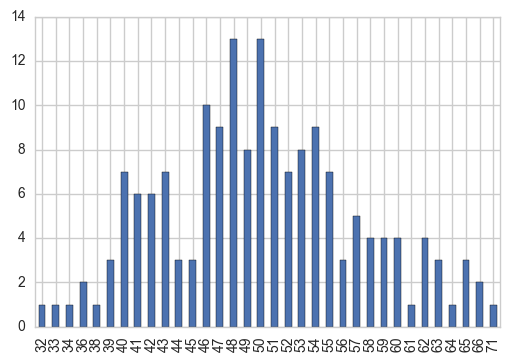

In [9]:
pd.Series((np.abs(Wr) > 0).sum(axis=0)).value_counts().sort_index().plot(kind='bar')

### Drug Weights

In [10]:
# RPPA->Drug weights should have at least some non-zero entries in columns or there will be no 
# connection between Genetic data and drug sensitivity outputs.  
# In addition, the mean number of non-zero entries should be p_drug
Wd.shape

(169, 25)

In [11]:
pd.Series((np.abs(Wd) > 0).sum(axis=0)).mean(), p_drug

(5.04, 5)

In [12]:
pd.Series((np.abs(Wd) > 0).sum(axis=0)).value_counts()

5     4
4     4
2     4
8     3
6     3
3     3
11    1
10    1
9     1
1     1
dtype: int64

# Cross Validation

In [86]:
# from ml.tensorflow import utilities as tf_utils
# tf.reset_default_graph()
# v = tf.contrib.distributions.StudentT(df=3., mu=0., sigma=.1).sample(100000)
# ax = pd.Series(tf_utils.tf_eval(v)).hist(bins=50)
# ax.set_yscale('symlog')

In [100]:
import imp
imp.reload(mklmodel)
imp.reload(ed_models)

<module 'ml.edward.models' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/edward/models.py'>

In [13]:
def get_mkl_model(fold_id):
    tf.reset_default_graph()
    model = mklmodel.MTKLModel(Xr.values, Yr.values, gamma=None, print_kernel_stats=False)
    est = ed_models.BayesianModelEstimator(
        model, n_collect=1, n_print_progress=500, random_state=SEED, 
        fail_if_not_converged=False, max_steps=3000,
        inference_fn=ed.MAP
    )
    est.set_log_dir('/tmp/mkl4sim/{}'.format(fold_id))
    return est

In [14]:
# ! rm -rf /tmp/mkl4sim/*
# get_mkl_model(0).fit(Xd.values, Yd.values)

In [15]:
# import imp
# imp.reload(trainer)

In [16]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from ml.edward import models as ed_models
from ml.api import trainer
from sklearn.model_selection import KFold
    
ests = {
    'lasso': lambda i: Pipeline([
        ('scale', StandardScaler()),
        #('pca', PCA(n_components=.9999)),
        ('est', MultiOutputRegressor(LassoCV(random_state=SEED, n_alphas=25)))
    ]),
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 6, 25))))
    ]),
    'svr': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(GridSearchCV(SVR(), {'C': np.logspace(-2, 5, 10)})))
    ]),
    'tkm': get_mkl_model,
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
}

K = 5
cv = KFold(n_splits=K, random_state=SEED, shuffle=True).split(Xd)

def fit_fn(est_name, est, X_train, Y_train, X_test, Y_test, fold):
    if est_name == 'tkm':
        est = est.fit(X_train.values, Y_train.values)
        est.all_tensors_ = est.get_all_tensors()
        return est
    else:
        return est.fit(X_train, Y_train)

config = trainer.TrainerConfig(refit=True, model_fit_fn=fit_fn)
cv_trainer = trainer.Trainer(config)

In [17]:
! rm -rf /tmp/mkl4sim/*
train_res = cv_trainer.train_regressors(Xd, Yd, ests, cv)

2017-04-19 06:24:18,635:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(X_train) = (36, 600), dim(X_test) = (10, 600), dim(Y_train) = (36, 25), dim(Y_test) = (10, 25)
2017-04-19 06:24:18,647:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (36, 600), dim(X_test) = (10, 600), dim(Y_train) = (36, 25), dim(Y_test) = (10, 25)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-04-19 06:24:20,674:INFO:ml.model.log: Running model ridge (Pipeline) on fold 1 ==> dim(X_train) = (36, 600), dim(X_test) = (10, 600), dim(Y_train) = (36, 25), dim(Y_test) = (10, 25)
2017-04-19 06:24:20,789:INFO:ml.model.log: Running model svr (Pipeline) on fold 1 ==> dim(X_train) = (36, 600), dim(X_test) = (10, 600), dim(Y_train) = (36, 25), dim(Y_test) = (10, 25)
2017-04-19 06:24:22,390:INFO:ml.model.log: Running model tkm (BayesianModelEstimator) on fold 1 ==> dim(X_train) = (36, 600), dim(X_test) = (10, 600), dim(Y_train) = (36, 25), dim(Y_test) = (10, 25)
2017-04-19 06:24:24,965:INFO:root: On iteration 0 of at most 3000 (loss = 3693621.5, loss change = None)
2017-04-19 06:24:27,446:INFO:root: On iteration

Beginning model refitting


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-04-19 06:25:57,843:INFO:ml.model.log: Running model ridge (Pipeline) on fold 0 ==> dim(X_train) = (46, 600), dim(X_test) = (46, 600), dim(Y_train) = (46, 25), dim(Y_test) = (46, 25)
2017-04-19 06:25:57,921:INFO:ml.model.log: Running model svr (Pipeline) on fold 0 ==> dim(X_train) = (46, 600), dim(X_test) = (46, 600), dim(Y_train) = (46, 25), dim(Y_test) = (46, 25)
2017-04-19 06:26:00,000:INFO:ml.model.log: Running model tkm (BayesianMode

In [18]:
from ml.api.results import predictions
d_pred = predictions.extract(train_res)
d_pred_melt = predictions.melt(train_res, d_pred)
d_pred_melt.head()

Actual  Fold     Model  Predicted Task
2   1.542337     1  baseline  -0.346539  DY0
3   4.246574     1  baseline  -0.346539  DY0
21 -4.938640     1  baseline  -0.346539  DY0
22 -2.883826     1  baseline  -0.346539  DY0
23  1.220735     1  baseline  -0.346539  DY0

In [353]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['tkm']

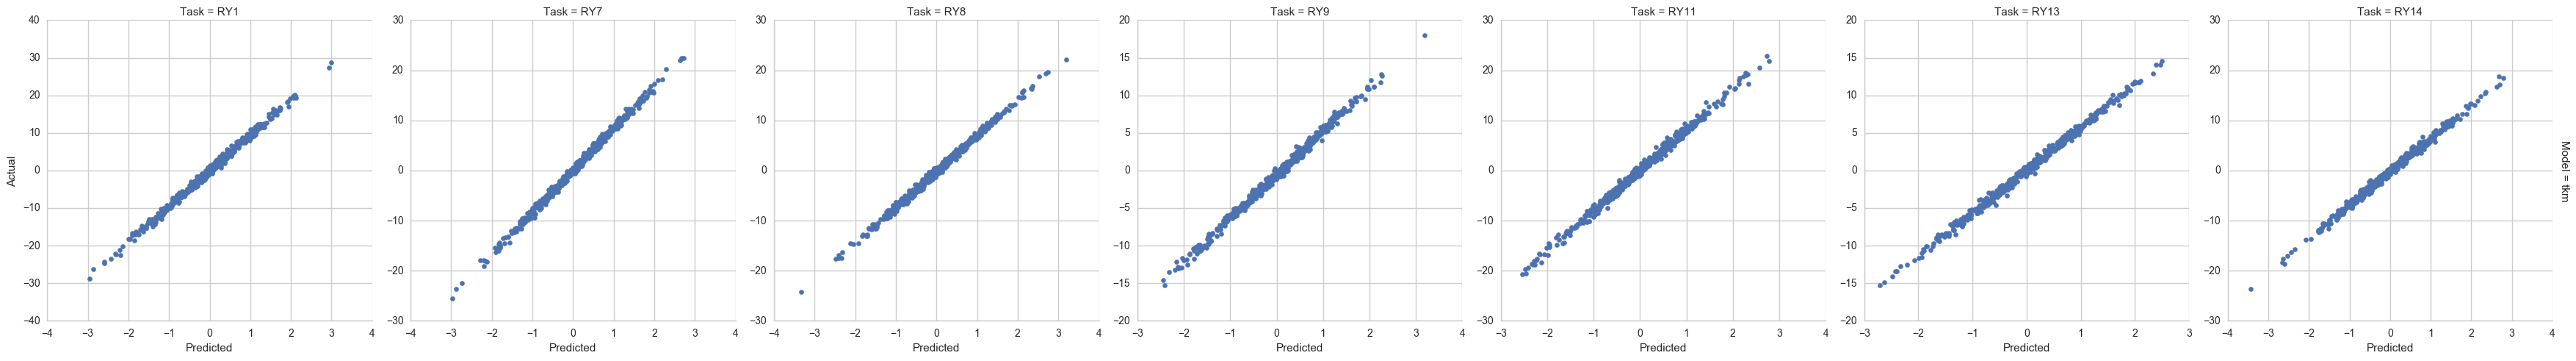

In [354]:
# Predictions on RPPA training data
Yp = pd.DataFrame(est.clf.get_tensor('qYR'), index=Yr.index, columns=Yr.columns)
d_pred_train = mkl.stack_predictions(Yp, Yr).reset_index().assign(Model='tkm', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, replace=False, random_state=SEED)
predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=False)
g.savefig(plot_file('pred_train_rppa.png'))

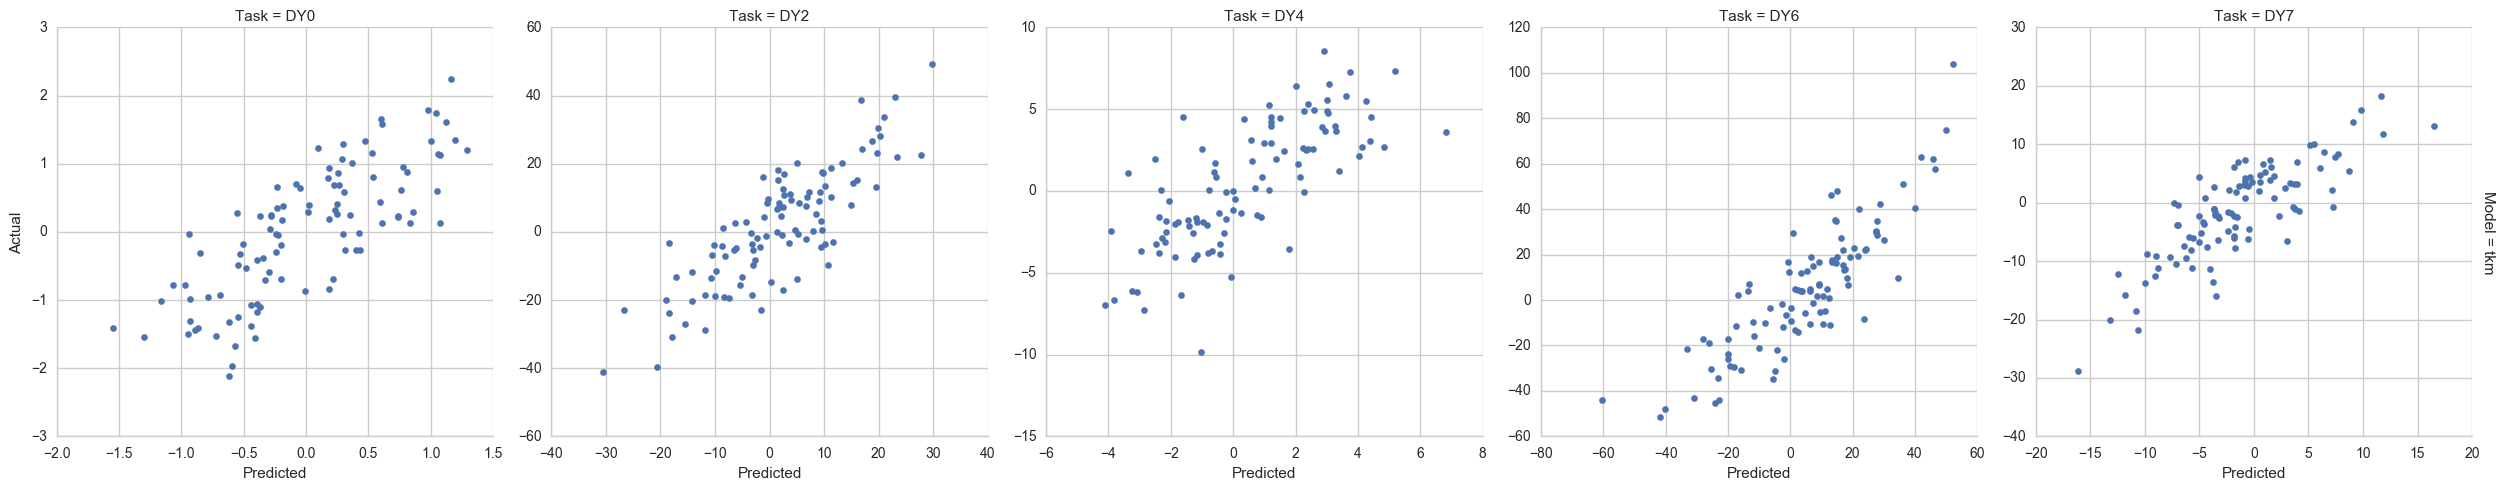

In [355]:
# Predictions on drug training data
Yp = est.clf.predict(Xd.values)
d_pred_train = mkl.stack_predictions(Yp, Yd).reset_index().assign(Model='tkm', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, replace=False, random_state=SEED)
predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=False)
g.savefig(plot_file('pred_train_drug.png'))

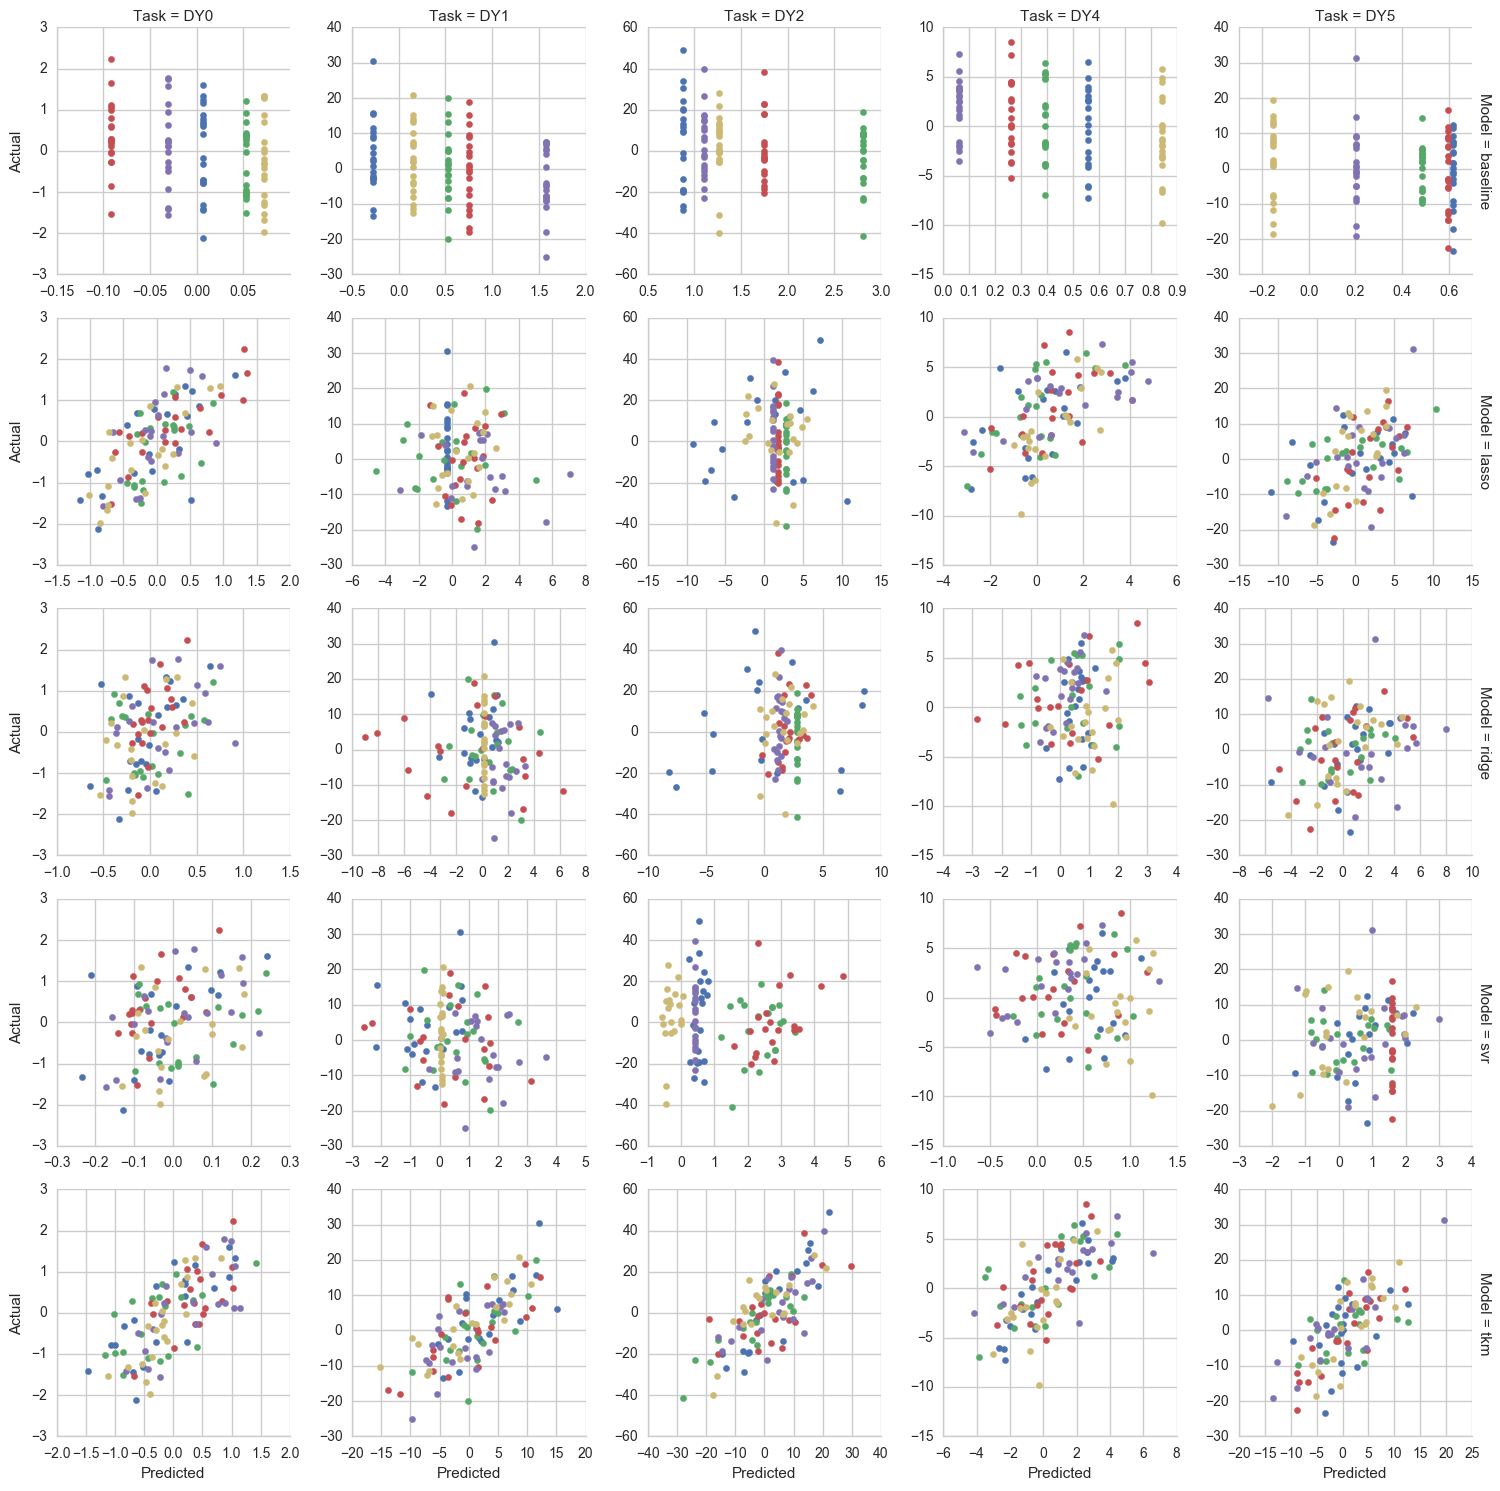

In [356]:
tasks = d_pred_melt['Task'].sample(n=10, random_state=SEED)
g = predictions.visualize(train_res, d_pred_melt[d_pred_melt['Task'].isin(tasks)], share_axes=False, figsize=3)
g.savefig(plot_file('pred_sample.png'))

In [19]:
from ml.api.results import performance
from sklearn.metrics import mean_squared_error, r2_score

def score_fn(y_true, y_pred):
    return {
        'pearson': y_true.corr(y_pred, method='pearson'),
        'spearman': y_true.corr(y_pred, method='spearman'),
        'r2_score': r2_score(y_true, y_pred)
    }
d_score = performance.extract(train_res, d_pred, score_fn, by_fold=True)
d_score = performance.melt(d_score)
d_score.head()

Model  Fold  Task    Metric         Value
0  baseline     1   DY0  r2_score -2.575112e-02
1  baseline     1   DY1  r2_score -5.667472e-02
2  baseline     1  DY10   pearson  3.555266e-17
3  baseline     1  DY10  r2_score -1.573750e-02
4  baseline     1  DY11  r2_score -4.480065e-02

In [21]:
def plot_scores(d, metric=None):
    traces = []
    for k, g in d.groupby('Metric'):
        if metric is not None and k != metric:
            continue
        trace = go.Box(x=g['Model'], y=g['Value'], boxmean='sd', boxpoints='all', name=k)
        traces.append(trace)
    layout = go.Layout(boxmode='group', hovermode='closest', title='CV Performance ({} Folds)<br>Metric = {}'.format(K, metric))
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    label = 'all' if metric is None else metric
    filename = plot_file('perf_scores_{}.html'.format(label))
    plty.offline.plt(fig, filename=filename)
    return filename

In [359]:
plot_scores(d_score)

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/small/perf_scores_all.html'

In [360]:
plot_scores(d_score, metric='pearson')

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/small/perf_scores_pearson.html'

# Effects

### TKL Model

In [23]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['tkm']
qW = est.clf.all_tensors_['qW']

In [24]:
qW.shape

(169, 25)

In [363]:
# plt.figure(figsize=(12, 5))
# sns.heatmap(np.where(np.abs(qW) < .15, np.nan, qW)[:25, :25])

In [364]:
# plt.figure(figsize=(12, 5))
# #sns.heatmap(np.where(Wd == 0, np.nan, Wd)[:25, :25])
# sns.heatmap(np.where(np.abs(Wd) < .1, np.nan, Wd)[:25, :25])

In [26]:
def plot_weights(W_true, W_pred):
    x = np.concatenate([np.arange(W_true.shape[1]) for i in range(W_true.shape[0])])
    y = np.concatenate([np.repeat(i, W_true.shape[1]) for i in range(W_true.shape[0])])
    z = W_true.ravel()
    
    drugs = ['Drug {}'.format(i) for i in range(W_pred.shape[1])]
    proteins = ['RPPA {}'.format(i) for i in range(W_pred.shape[0])]
    
    traces = []
    traces.append(go.Heatmap(
        x=drugs, 
        y=proteins,
        z=W_pred, 
        colorscale='Portland', 
        reversescale=True,
        opacity=.5,
        colorbar=go.ColorBar(title='Weight Value'),
        text=pd.DataFrame(W_pred).applymap(lambda v: 'Estimated Weight: {}'.format(v)).values,
        hoverinfo='x+y+text'
    ))
    for i in range(W_true.shape[0]):
        weights = W_true[i,:]
        trace = go.Scatter(
            x=drugs,
            y=np.repeat(proteins[i], len(weights)),
            mode='markers',
            marker=dict(
                size=np.where(np.abs(weights) > 0, 10, 0),
                color=np.where(weights > 0, 'rgb(31, 119, 180)', 'rgb(214, 39, 40)')
            ),
            text=pd.Series(W_true[i,:]).apply(lambda v: 'Actual Weight: {}'.format(v) if not pd.isnull(v) else np.nan),
            hoverinfo='x+y+text',
            showlegend=False
        )
        traces.append(trace)
    layout = go.Layout(
        height=800, 
        hovermode='closest',
        title='Actual vs Estimated Weight Values<br>(dots=Actual, bars=Estimated)'
    )
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    filename = plot_file('weight_estimate_tkm.html')
    plty.offline.plt(fig, filename=filename)
    return filename

In [27]:
plot_weights(
    np.where(np.abs(Wd) < .5, np.nan, Wd)[:,:],
    np.where(np.abs(qW) < .2, np.nan, qW)[:,:]
)

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning:

invalid value encountered in greater

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning:

invalid value encountered in greater



'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/large/weight_estimate_tkm.html'

## Lasso

In [33]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['lasso']
qW = []
for e in est.clf.named_steps['est'].estimators_:
    qW.append(e.coef_)
qW = pd.DataFrame(qW).T
qW.shape

(600, 25)

In [34]:
def plot_weight_estimates(W_pred, model='Lasso'):
    
    drugs = ['Drug {}'.format(i) for i in range(W_pred.shape[1])]
    proteins = ['Gene {}'.format(i) for i in range(W_pred.shape[0])]
    
    traces = []
    traces.append(go.Heatmap(
        x=drugs, 
        y=proteins,
        z=W_pred, 
        colorscale='Portland', 
        reversescale=True,
        opacity=.5,
        colorbar=go.ColorBar(title='Weight Value'),
        text=pd.DataFrame(W_pred).applymap(lambda v: 'Estimated Weight: {}'.format(v)).values,
        hoverinfo='x+y+text'
    ))
    layout = go.Layout(
        height=2000, 
        hovermode='closest',
        title='Estimated Weight Values<br>({} Model)'.format(model)
    )
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    filename = plot_file('weight_estimate_{}.html'.format(model.lower()))
    #plty.offline.plt(fig, filename=filename)
    return filename
    
plot_weight_estimates(
    np.where(np.abs(qW) < .001, np.nan, qW)[:,:],
    model='Lasso'
)

# plot_surface(
#     np.array([[1,2], [3,4], [5,6]]),
#     np.array([[1,2], [3,4], [5,6]])
# )

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/large/weight_estimate_lasso.html'

# Parameter Count Estimates

In [368]:
# Counts for simulation (small)
p_tkm = (Nr * Tr) + (Tr * Td)
p_lasso = P * Td
p_tkm, p_lasso

(7620, 4800)

In [334]:
# Counts for simulation (large)
p_tkm = (Nr * Tr) + (Tr * Td)
p_lasso = P * Td
p_tkm, p_lasso

(72332, 15000)

In [335]:
# Counts for actual

# NOTE: * does not need to be rerun based on configuration

# Actual Config
# P = 13415
# Nr = 403
# Nd = 46
# Tr = 169
# Td = 196
# p_rppa = 100
# p_drug = 5

p_tkm = (403 * 169) + (169 * 196)
p_lasso = 13415 * 196
p_tkm, p_lasso

(101231, 2629340)